## Utilities

In [1]:
from d2l import torch as d2l # for HyperParameters class
import torch

In [2]:
def pad(X, padding): #optimized to use slicing instead of nested loops for element-wise assignments
    if(len(X.shape) == 4):
        h = X.shape[2]
        w = X.shape[3]
        padded_X = torch.zeros(X.shape[0], X.shape[1], 2*padding + h, 2*padding + w)
        for idx in range(X.shape[0]): #idx of example in batch size
            padded_X[idx, 0, padding:padding+h, padding:padding+w] = X[idx] #shallow copy
            
        return padded_X
    else: #2 dimension
        h = X.shape[0]
        w = X.shape[1]
        padded_X = torch.zeros(2*padding + h, 2*padding + w)
        padded_X[padding:padding+h, padding:padding+w] = X #shallow copy
        return padded_X

#Example
X = torch.ones(2,2)
pad_res = pad(X, 1)
print(pad_res)
print(pad_res.grad_fn)

tensor([[0., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.]])
None


In [72]:
def cross_correlation(X, k, i, j): #optimized to use slicing instead of nested loops for element-wise assignments
    assert k.shape[0] == k.shape[1] #kernel is sqaure matrix
    X_conv = torch.zeros_like(k, dtype=float)
    
    if k.shape[0] % 2 == 1: # if kernel size is odd
        offset = int(k.shape[0]/2)
        X_conv = X[i-offset:i+offset+1, j-offset:j+offset+1] * k
    else: # if kernel size is even (works with pooling)
        offset = k.shape[0] - 1
        X_conv = X[i-offset:i+1, j-offset:j+1] * k
    return X_conv.sum()

        
             
#Example 1
print('Example 1\n')
X = pad(torch.ones((2,2), dtype=float), padding = 2)
k = torch.randint(0, 4, (3, 3), dtype=float)
print(X)
print(k)
print(cross_correlation(X, k, 2, 2), '\n')

#Example 2
print('Example 2\n')
X = torch.randint(0, 10, (5, 5), dtype = float)
k = torch.ones((2, 2), dtype = float) * 0.25
print(X)
print(k)
print(cross_correlation(X, k, 4, 4))

Example 1

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 3.],
        [1., 0., 2.],
        [3., 1., 3.]], dtype=torch.float64)
tensor(6., dtype=torch.float64) 

Example 2

tensor([[9., 7., 8., 5., 6.],
        [0., 7., 7., 6., 7.],
        [8., 4., 8., 2., 1.],
        [9., 6., 3., 7., 8.],
        [6., 2., 6., 5., 0.]], dtype=torch.float64)
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]], dtype=torch.float64)
tensor(5., dtype=torch.float64)


## Architecture

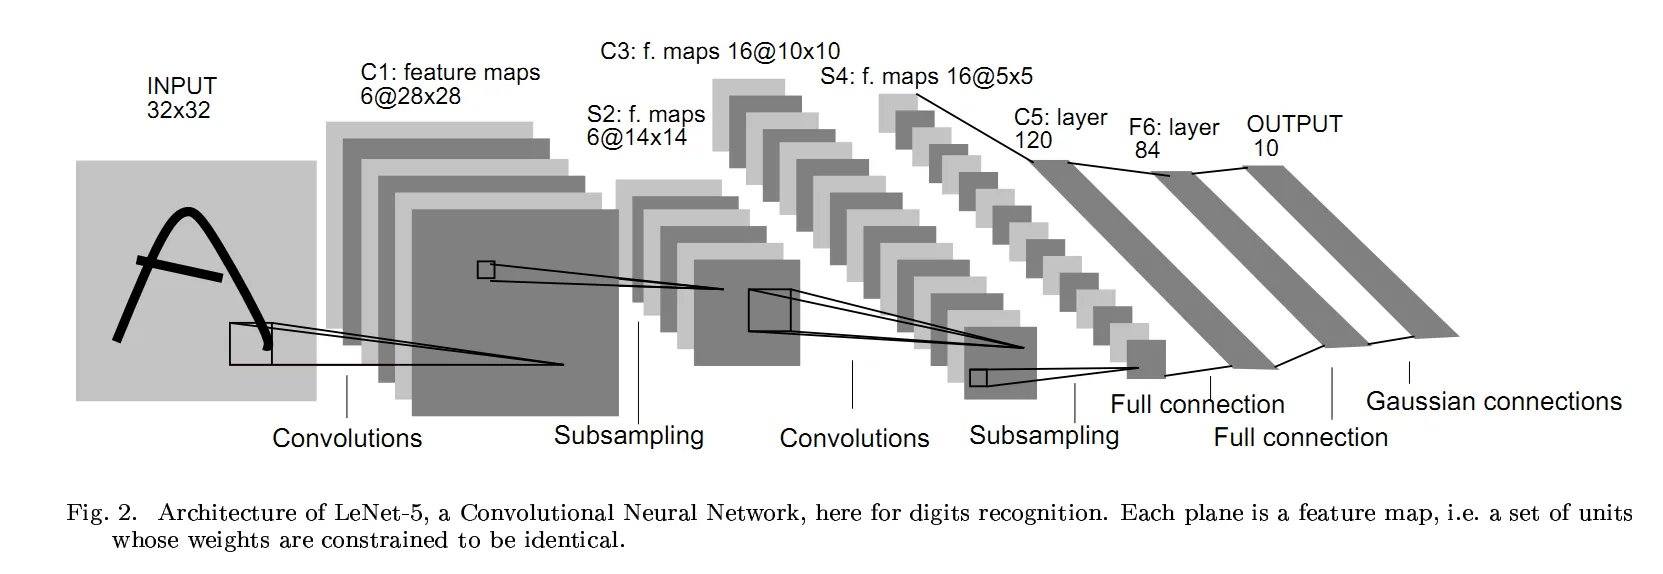

Paper: Gradient-Based Learning Applied to Document Recognition

Authors: Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner

Published in: Proceedings of the IEEE (1998)

## Data

In [4]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt

In [5]:
Data = FashionMNIST(root = '../Data/', train = True, download = True, transform = ToTensor())

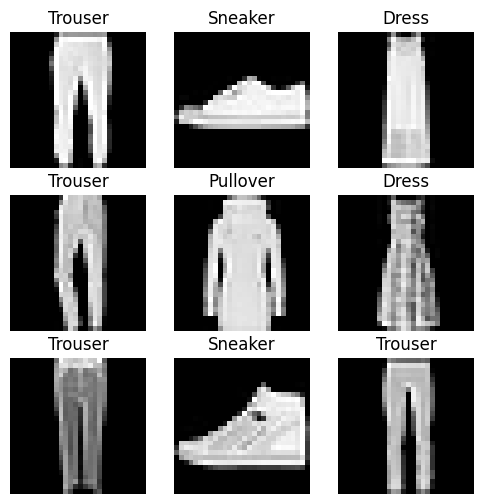

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(Data), size=(1,)).item()
    img, label = Data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
data_loader = DataLoader(Data, batch_size=32,shuffle=True)

## Conv2d

In [8]:
from torch import nn

In [9]:
class Conv2d(d2l.HyperParameters, nn.Module):
    
    def __init__(self, output_channels, padding = 2, kernal_size = 5): #for kernal 5 padding 2 is suitable
        super().__init__()
        self.save_hyperparameters()
        self.kernel = nn.Parameter(data = torch.randn((output_channels, kernal_size, kernal_size)), 
                                   requires_grad=True)
    
    def forward(self, X): #shape (batch, channels, height, width)
        assert X.shape[1] == 1 #only accept images of 1 channel
        padded_X = pad(X, self.padding)
        batch_size = padded_X.shape[0]
        h = X.shape[2]
        w = X.shape[3]
        output = torch.zeros(batch_size, self.output_channels, h, w)
        for idx in range(batch_size):
            for c in range(self.output_channels):
                for i in range(self.padding, h + self.padding):
                    for j in range(self.padding, w + self.padding):
                        output[idx][c][i-self.padding][j- self.padding] = cross_correlation(padded_X[idx][0], self.kernel[c], i, j)
        return output
                

In [10]:
conv2d = Conv2d(6, 2, 5)
X = next(iter(data_loader))
# print(X[0])
features = X[0]
labels = X[1]
print(features.shape)
res = conv2d(features)
res.shape

torch.Size([32, 1, 28, 28])


torch.Size([32, 6, 28, 28])

### Time Complexity of ```Conv2d.forward```

**Number of Operations done the the forward function inside the loop ```for idx in range(batch_size):``` (addition & multiplication)**
$$b \times c \times h \times w \times k^2 \times 2$$

**Where**

$\textbf{b}$:  batch size

$\textbf{c}$: number of output channels

$\textbf{h}$: image height

$\textbf{w}$: image width

$\textbf{k}$: kernel dimension

$\textbf{2}$: number of core operations happening inside ```cross_correlation``` (one addition & one multiplication)

let $h = w = 28$ and let $k$ = 5

for $c = 6$ we have the following figure:

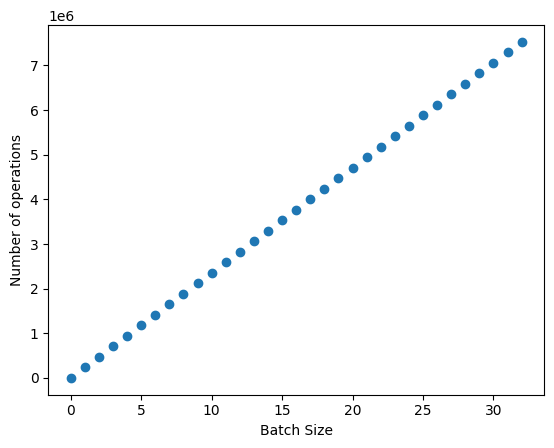

In [29]:
B = torch.tensor(list(range(33)))
num_ops = B * (2 * 5 * 5 * 28 * 28 * 6)
plt.scatter(B, num_ops)
plt.xlabel('Batch Size')
plt.ylabel('Number of operations')
plt.show()

The figure shows the number of operations as a function of the batchsize. For a batchsize of 32 we have the number of operations exceeding **7 Millions!**

### Reducing time complexity

After using slicing within ```pad``` and ```cross_correlation``` functions a major increase in performance was obtained

## Sigmoid

In [24]:
class Sigmoid(d2l.HyperParameters, nn.Module):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        
    def forward(self, X):#of shape (example, channel, height, width)
        output = torch.zeros_like(X)
        for idx in range(X.shape[0]):
            for c in range(X.shape[1]):
                print('print current X:\n', X[idx, c])
                output[idx, c] = torch.sigmoid(X[idx, c])
        return output


In [28]:
seg = Sigmoid()
res2 = seg(res)

print current X:
 tensor([[ 0.0000e+00,  0.0000e+00,  8.1273e-03,  8.2870e-03, -1.3553e-03,
          7.9876e-02,  1.4684e+00,  3.1865e+00,  3.7994e+00,  4.6222e+00,
          4.7277e+00,  4.0710e+00,  2.6393e+00,  2.2327e+00,  2.0780e+00,
          2.4226e+00,  2.1869e+00,  1.1377e+00,  6.3369e-01,  5.3260e-01,
         -1.4866e-01, -2.5594e-01, -7.2855e-02, -3.8386e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.9498e-03,  4.6104e-03,  5.1631e-01,
          2.4010e+00,  4.3029e+00,  4.9634e+00,  4.2953e+00,  3.2094e+00,
          2.6192e+00,  1.5742e+00,  1.8590e+00,  1.6467e+00,  1.6002e+00,
          1.4257e+00,  1.5243e+00,  1.3497e+00,  1.2736e+00,  1.3643e+00,
          5.7809e-01, -9.8636e-01, -1.5401e+00, -3.2191e-01, -8.2066e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.4898e-03,  4.2682e-03,  1.9313e+00,
          4.6725e+00,  4.7831e+00,  4.2629e+00,  2.5563e+00,  2.1326e+

 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0

 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  2.5333e-01,  1.3108e-01,
         -1.1867e+00, -2.0360e+00,  4.7787e-01,  4.4177e-01,  1.3751e-01,
         -3.6861e-01, -7.3260e-01, -1.3846e+00, -1.1544e+00,  9.4618e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.1278e-03,  3.8427e-01,  1.2183e+00,
         -1.5698e+00, -2.5616e+00, -5.4546e-01,  9.2029e-01,  5.1739e-01,
         -1.2805e-01,  6.1012e-01, -1.8748e+00, -4.0506e-01,  1.3882e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.1046e-02,  4.7738e-01,  2.5159e+00,
         -4.3

In [29]:
res2.shape

torch.Size([32, 6, 28, 28])

## AvgPool2d

In [75]:
class AvgPool2d(d2l.HyperParameters, nn.Module):
    def __init__(self, kernel_size = 2, method = 'avg'):
        super().__init__()
        self.save_hyperparameters()
        self.k = torch.ones((kernel_size, kernel_size), dtype = float)
        self.k = self.k * 1/(kernel_size**2)
    def forward(self, X): #shape (example, channel, height, width)
        sub = int(k.shape[0]/2)
        output = torch.zeros((X.shape[0], X.shape[1], X.shape[2]-sub, X.shape[3]-sub))
        for idx in range(X.shape[0]):
            for c in range(X.shape[1]):
                for i in range(output.shape[2]):
                    for j in range(output.shape[3]):
                        output[idx, c, i, j] = cross_correlation(X[idx, c], self.k, i+sub, j+sub)
        return output

In [76]:
pool = AvgPool2d(2, 'avg')
X = torch.randint(0, 10, (1, 1, 5, 5), dtype = float)
print(X)
pool(X)

tensor([[[[5., 6., 8., 3., 6.],
          [2., 9., 6., 1., 6.],
          [6., 6., 8., 3., 2.],
          [4., 8., 1., 6., 8.],
          [0., 2., 4., 3., 9.]]]], dtype=torch.float64)


tensor([[[[5.5000, 7.2500, 4.5000, 4.0000],
          [5.7500, 7.2500, 4.5000, 3.0000],
          [6.0000, 5.7500, 4.5000, 4.7500],
          [3.5000, 3.7500, 3.5000, 6.5000]]]])

In [77]:
res3 = pool(res2)

## Flatten

In [79]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def  forward(self, X):
        return X.reshape((X.shape[0], X.shape[1], -1))

## Linear

In [151]:
class Linear(nn.Module, d2l.HyperParameters):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.save_hyperparameters()
        self.W = nn.Parameter(data = torch.randn((n_output, n_input), dtype = float), requires_grad=True)
        self.b = nn.Parameter(data = torch.zeros((n_output, 1), dtype = float), requires_grad=True)
        
    def forward(self, X): #shape (example, data)
        output = torch.zeros(X.shape[0], self.n_output)
        for idx in range(output.shape[0]):
#             print('W\n', self.W)
#             print('X[idx]', X[idx].reshape((len(X[idx]), 1)))
#             print('output', output)
            output[idx] = (torch.matmul(self.W, X[idx].reshape((len(X[idx]), 1))) + self.b).reshape((self.n_output))
        return output


In [174]:
n_features = 3
l = Linear(n_input = n_features, n_output = 4) 
X = torch.randint(0, 10, (3, n_features), dtype = float) #3 examples, each example is 10 features = n_input
print(X)
print(l.W)
l(X)

tensor([[5., 6., 6.],
        [4., 7., 7.],
        [6., 9., 1.]], dtype=torch.float64)
Parameter containing:
tensor([[-1.1250, -0.6538, -0.1069],
        [-0.2040, -1.1717,  0.4414],
        [ 0.3442,  2.4230,  0.9725],
        [-0.0162,  1.2556, -0.1134]], dtype=torch.float64, requires_grad=True)


tensor([[-10.1894,  -5.4024,  22.0938,   6.7722],
        [ -9.8252,  -5.9287,  25.1451,   7.9306],
        [-12.7414, -11.3284,  24.8443,  11.0900]], grad_fn=<CopySlices>)